## Notebook 2: Segmentation of satellite images of water bodies using pretrained Resnet-50 model in Pytorch

The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I applied the pretrained DeepLabV3 ResNet-50 model in Pytorch to perform segmentation on the water body images. I chose the DeepLabV3 semantic segmentation architecture because of its effectiveness and simplicity.

**1. Prepare Problem**

In [1]:
# a) Load libraries

import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Check if GPU parallel computing is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
# b) Prepare dataset
# Here I selected large images height and width to improve training performance
height = width = 500 
batch = 11

ImagesFolder = "/content/drive/MyDrive/Colab Notebooks/Images"
MasksFolder = "/content/drive/MyDrive/Colab Notebooks/Masks"

# Create lists of image and mask
ListImages = sorted(os.listdir(os.path.join(ImagesFolder))) 
ListMasks = sorted(os.listdir(os.path.join(MasksFolder)))

print(len(ListImages), len(ListMasks))

2838 2838


In total, there are 2,838 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

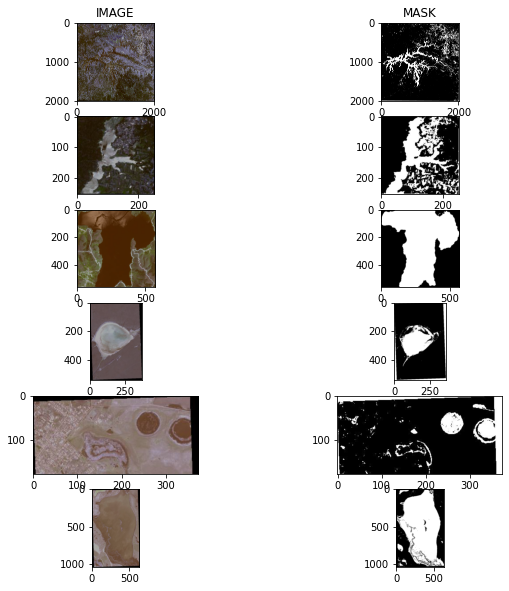

In [3]:
# c) Image visualization
# plot first few images in Images and Masks folder 
f, axr = plt.subplots(6, 2, figsize=(10, 10))
i = 0 
for i in range(6):
    original = cv2.imread(os.path.join(ImagesFolder, ListImages[i]))
    mask = cv2.imread(os.path.join(MasksFolder, ListMasks[i]), 0)
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask, cmap = 'gray')
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different shapes. The differences in shape between the images and masks may present challenges during the transformation and training processes.

**3. Prepare Data**

In [4]:
# a) Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(ListImages, ListMasks, test_size=0.25, random_state=1)
print(len(X_train), len(y_train))

2128 2128


In [5]:
# b) Load images in Images and Masks folders
# Create a preprocessing pipeline for images and masks
tfImg = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
tfMsk = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        ])

In [6]:
# Create a function to read images and masks randomly
def ReadImage(image_dir, mask_dir):
    idx = np.random.randint(0, len(image_dir))
    Img = cv2.imread(os.path.join(ImagesFolder, image_dir[idx]))
    Msk =  cv2.imread(os.path.join(MasksFolder, mask_dir[idx]), 0) # Load grayscale masks
    Img = tfImg(Img)
    Msk = tfMsk(Msk)
    return Img, Msk

In [7]:
# Create a function to load images and masks in batch
def LoadBatch(image_dir, mask_dir):
    images = torch.zeros([batch, 3, height, width])
    masks = torch.zeros([batch, height, width])
    for i in range(batch):
        images[i], masks[i] = ReadImage(image_dir, mask_dir)
    return images, masks

**4. Evaluate Models**

In [8]:
# a) Define pretrained ResNet-50 model using TorchVision DeepLabV3 architecture
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained = True)

# Since the segmented images have 2 classes (black and white), we change the final layer to 2 classes
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size = (1, 1), stride = (1, 1)) 
model = model.to(device)

# Select Stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 (optimum for image segmentation)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [9]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss() 
Losses = []

In [10]:
# b) Evaluation of train dataset
epochs = 1600

# Training loop
for itr in range(epochs):
   images, masks = LoadBatch(X_train, y_train)
   # Load images and masks tensors to the GPU 
   images = torch.autograd.Variable(images,requires_grad = False).to(device) 
   masks = torch.autograd.Variable(masks, requires_grad = False).to(device) 
   
   # Forward training loop
   Pred = model(images)['out']
   model.zero_grad()
   Loss = criterion(Pred, masks.long())
   Losses.append(Loss.item())

   # Backward training loop
   Loss.backward() 
   optimizer.step() # Apply gradient descent to optimize weights
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss.data.cpu().numpy())

0 ) Loss= 0.7394021
1 ) Loss= 0.79581773
2 ) Loss= 0.71546435
3 ) Loss= 0.68300074
4 ) Loss= 0.6391778
5 ) Loss= 0.59871393
6 ) Loss= 0.5801625
7 ) Loss= 0.615766
8 ) Loss= 0.5965737
9 ) Loss= 0.6030549
10 ) Loss= 0.51944107
11 ) Loss= 0.5340706
12 ) Loss= 0.47668973
13 ) Loss= 0.64542645
14 ) Loss= 0.4905561
15 ) Loss= 0.48616776
16 ) Loss= 0.5144225
17 ) Loss= 0.47490537
18 ) Loss= 0.466203
19 ) Loss= 0.5510035
20 ) Loss= 0.6536494
21 ) Loss= 0.5288653
22 ) Loss= 0.51168776
23 ) Loss= 0.47022846
24 ) Loss= 0.422496
25 ) Loss= 0.45733023
26 ) Loss= 0.44668314
27 ) Loss= 0.39330158
28 ) Loss= 0.43962812
29 ) Loss= 0.47418472
30 ) Loss= 0.44259924
31 ) Loss= 0.54580647
32 ) Loss= 0.40854272
33 ) Loss= 0.4427174
34 ) Loss= 0.42013374
35 ) Loss= 0.322975
36 ) Loss= 0.3938931
37 ) Loss= 0.45594937
38 ) Loss= 0.44711095
39 ) Loss= 0.3817325
40 ) Loss= 0.457938
41 ) Loss= 0.4358002
42 ) Loss= 0.44427958
43 ) Loss= 0.33267257
44 ) Loss= 0.3473638
45 ) Loss= 0.4089847
46 ) Loss= 0.2927475
47 )

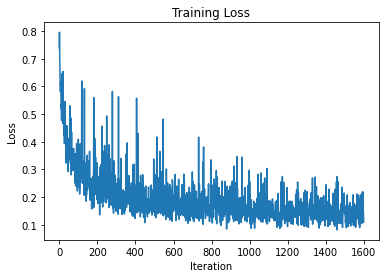

In [11]:
# Plot the training loss values
plt.plot(Losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

The results of training the model show that the loss values are improved compared to the TensorFlow model. It seems that the optimal number of epochs for achieving good loss values is around 1000, and increasing the number of epochs beyond this point does not significantly improve training performance. 

Now that the model has been trained, we can proceed to testing it with new images.

In [12]:
# Set trained model to the evaluation mode for validation test set
model.eval() 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
Losses_val = []

with torch.no_grad(): # Set context to not calculate and save gradients
  correct = 0
  total = 0
  for itr in range(epochs):
   images_val, masks_val = LoadBatch(X_val, y_val)
   # Load images and masks tensors to the GPU 
   images_val = torch.autograd.Variable(images_val,requires_grad = False).to(device) 
   masks_val = torch.autograd.Variable(masks_val, requires_grad = False).to(device) 
   
   Pred_val = model(images_val)['out']
   model.zero_grad()
   Loss_val = criterion(Pred_val, masks_val.long())
   Losses_val.append(Loss_val.item())

   seg = torch.argmax(Pred_val[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss_val.data.cpu().numpy())

0 ) Loss= 0.49497145
1 ) Loss= 0.12445112
2 ) Loss= 0.14321753
3 ) Loss= 0.16406743
4 ) Loss= 0.09056511
5 ) Loss= 0.11864502
6 ) Loss= 0.1388051
7 ) Loss= 0.15221143
8 ) Loss= 0.20828705
9 ) Loss= 0.18172227
10 ) Loss= 0.116598286
11 ) Loss= 0.115568906
12 ) Loss= 0.18428227
13 ) Loss= 0.09532741
14 ) Loss= 0.15157185
15 ) Loss= 0.5128015
16 ) Loss= 0.14761414
17 ) Loss= 0.122442044
18 ) Loss= 0.5429774
19 ) Loss= 0.14943318
20 ) Loss= 0.34317505
21 ) Loss= 0.07808585
22 ) Loss= 0.582413
23 ) Loss= 0.09863434
24 ) Loss= 0.1132502
25 ) Loss= 0.097159326
26 ) Loss= 0.1417532
27 ) Loss= 0.10997857
28 ) Loss= 0.15177317
29 ) Loss= 0.148166
30 ) Loss= 0.1191241
31 ) Loss= 0.2175264
32 ) Loss= 0.20837437
33 ) Loss= 0.109998226
34 ) Loss= 0.117075525
35 ) Loss= 0.19404285
36 ) Loss= 0.1498172
37 ) Loss= 0.2059019
38 ) Loss= 0.15868938
39 ) Loss= 0.17407802
40 ) Loss= 0.14564028
41 ) Loss= 0.12558572
42 ) Loss= 0.1356772
43 ) Loss= 0.40247688
44 ) Loss= 0.22683127
45 ) Loss= 0.11615009
46 ) L

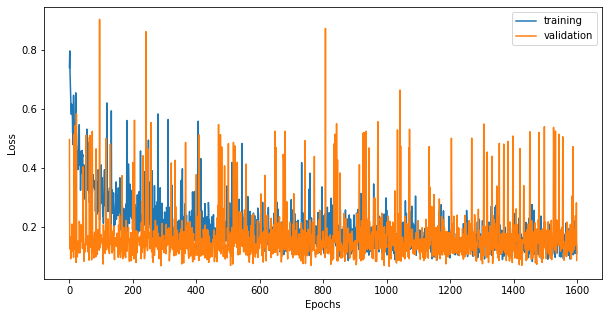

In [14]:
# Plot the training loss values
plt.figure(figsize = (10, 5))
plt.plot(Losses, label = 'training')
plt.plot(Losses_val, label = 'validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The consistency between the training and validation losses suggests that the model is capable of accurately predicting on new data.

**5. Finalize Model**

In [15]:
# a) Predictions on new images and masks 
# Set trained model to the evaluation mode
model.eval() 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [16]:
Img1 = cv2.imread("water_body_2170.jpg")
Img2 = cv2.imread("water_body_1027.jpg")
Img3 = cv2.imread("water_body_760.jpg")
Msk1 = cv2.imread("water_body_2170msk.jpg")
Msk2 = cv2.imread("water_body_1027msk.jpg")
Msk3 = cv2.imread("water_body_760msk.jpg")

# Get images original size for conversion after segmentation 
height_orgin1, width_orgin1, d1 = Img1.shape 
height_orgin2, width_orgin2, d2 = Img2.shape
height_orgin3, width_orgin3, d3 = Img3.shape

# Transform images to tensors
Img1t = tfImg(Img1)  
Img2t = tfImg(Img2)
Img3t = tfImg(Img3)

# Load tensor images to GPU
Img1t = torch.autograd.Variable(Img1t, requires_grad = False).to(device).unsqueeze(0)
Img2t = torch.autograd.Variable(Img2t, requires_grad = False).to(device).unsqueeze(0)
Img3t = torch.autograd.Variable(Img3t, requires_grad = False).to(device).unsqueeze(0)

In [17]:
# Perform image segmentation
with torch.no_grad(): # Set context to not calculate and save gradients
    Prd1 = model(Img1t)['out']
    Prd2 = model(Img2t)['out']
    Prd3 = model(Img3t)['out']
    
# Resize segmented images to origninal sizes
Prd1 = tf.Resize((height_orgin1,width_orgin1))(Prd1[0]) 
Prd2 = tf.Resize((height_orgin2,width_orgin2))(Prd2[0])
Prd3 = tf.Resize((height_orgin3,width_orgin3))(Prd3[0])

# Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array for plotting
seg1 = torch.argmax(Prd1, 0).cpu().detach().numpy()  
seg2 = torch.argmax(Prd2, 0).cpu().detach().numpy()
seg3 = torch.argmax(Prd3, 0).cpu().detach().numpy()

The trained model appears to be effective at performing segmentation on new images that it was not trained on.

Text(0.5, 1.0, 'SEGMENTATION')

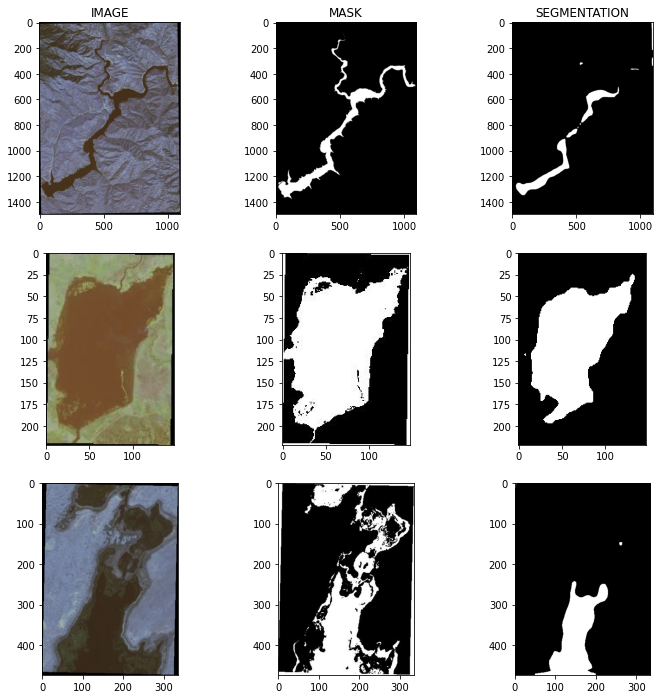

In [18]:
# Plot images, masks, and corresponding segmentations 
f, axr = plt.subplots(3, 3, figsize=(12, 12))
axr[0,0].imshow(Img1)
axr[0,1].imshow(Msk1, cmap="gray")
axr[0,2].imshow(seg1, cmap="gray")
axr[1,0].imshow(Img2)
axr[1,1].imshow(Msk2, cmap="gray")
axr[1,2].imshow(seg2, cmap="gray")
axr[2,0].imshow(Img3)
axr[2,1].imshow(Msk3, cmap="gray")
axr[2,2].imshow(seg3, cmap="gray")
axr[0, 0].set_title("IMAGE")
axr[0, 1].set_title("MASK")
axr[0, 2].set_title("SEGMENTATION")

In [ ]:
# b) Save the model for later use
# save the best model's weights to a file for future inference
torch.save(model.state_dict(), "best_model.pth")

**6. Conclusions**

- To prepare satellite images for processing with a pretrained Resnet-50 model for segmentation, it is necessary to resize, normalize, and convert them to tensors.

- Increasing the size of the images and the number of epochs and image samples can enhance the performance of the training process.

- The DeepLabV3 architecture is a highly effective pretrained model for semantic segmentation in pytorch, despite its simplicity.

- To achieve slightly better training losses over the Keras model (0.10 vs. 0.16), the computational demands of the DeepLabV3 model using pytorch are significantly higher and can only be met through the use of GPU parallel computing.